In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from numpy import shape
import csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import pickle

# My imports
import generative_models.load as load

In [2]:
# Load dataset
# Load dataset
filename_wind = 'generative_models/data/less_windy.csv'
#trX, trY, X_test, Y_test = load.load_wind(filename_wind, sample_size=2)

# filename_solar = 'generative_models/data/solar.csv'
# trX, X_test = load.load_solar(filename_solar, sample_size=2)

# Load solar dataset from 2006
filename_solar_2006 = 'generative_models/data/solar_2006.csv'
file_labels = 'generative_models/data/solar label.csv'
trX, X_test, trY, y_test = load.load_solar_2006(filename_solar_2006, file_labels, testsize=0.2, sample_size=2)
max_output = 74
num_categories = 12
trX, X_test = trX / max_output, X_test / max_output

print("Shape of training samples ", shape(trX))
print("Training data loaded")

Solar data loaded
Total number of samples: 5824
Shape of training dataset: (4659, 576)
Shape of test datasaet: (1165, 576)
Shape of training samples  (4659, 576)
Training data loaded


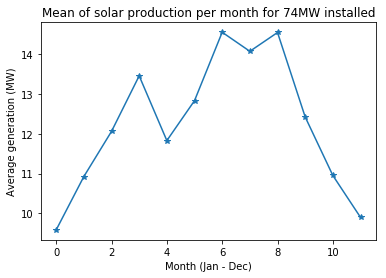

In [24]:
# Statistics about training data
mean_per_category = []
for i in range(num_categories):
    subset = trX[trY.flatten() == i]
    mean_per_category.append(np.mean(subset) * max_output)
plt.plot(mean_per_category, marker='*')
plt.title('Mean of solar production per month for 74MW installed')
plt.xlabel('Month (Jan - Dec)')
plt.ylabel('Average generation (MW)')
plt.savefig('../VER_GenerativeModelling_RLAllocation/generative_models/figures/solar_mean_per_month.png')

In [3]:
# Create OneHot encoder to encode labels
enc = OneHotEncoder(sparse=False)
enc.fit(trY)

/anaconda3/envs/cs159/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:414: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='error',
              n_values=None, sparse=False)

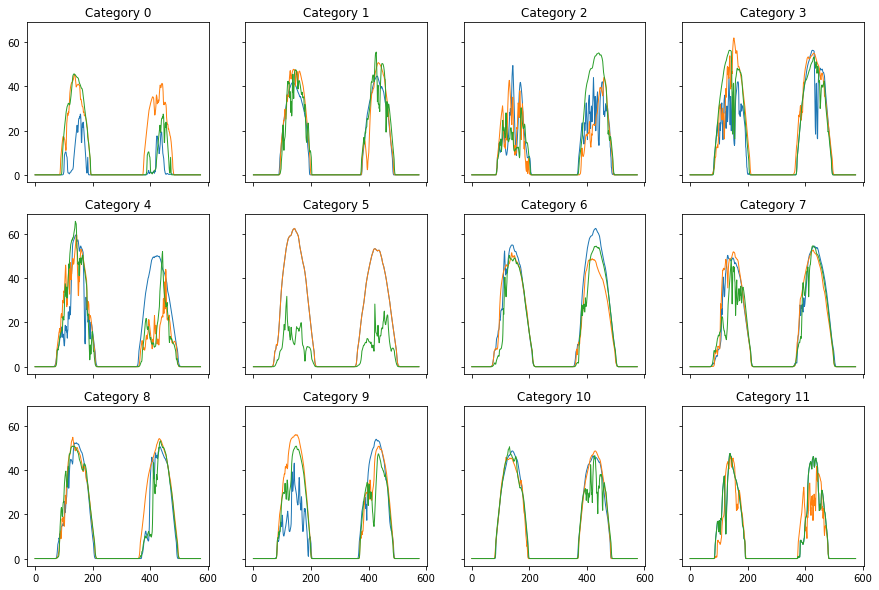

In [4]:
# Plot examples of each category
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(15, 10))
axes = axes.flatten()

for i in range(12):

    index = (trY == i).flatten()
    subset = trX[index]

    example = subset[np.random.randint(subset.shape[0], size=3)]
    example = example * max_output

    ax = axes[i]
    for e in example:
        ax.plot(e, linewidth=1.)
    ax.title.set_text(f'Category {i}')

# plt.savefig('../VER_GenerativeModelling_RLAllocation/generative_models/figures'
#             '/solar_categories_examples.png',
#             tight_layout=True)
plt.show()

In [5]:
### model.py file ###

#The GANs model with Wasserstein distance along with helper functions

def batchnormalize(X, eps=1e-8, g=None, b=None):
    if X.get_shape().ndims == 4:
        mean = tf.reduce_mean(X, [0,1,2])
        std = tf.reduce_mean( tf.square(X-mean), [0,1,2] )
        X = (X-mean) / tf.sqrt(std+eps)

        if g is not None and b is not None:
            g = tf.reshape(g, [1,1,1,-1])
            b = tf.reshape(b, [1,1,1,-1])
            X = X*g + b

    elif X.get_shape().ndims == 2:
        mean = tf.reduce_mean(X, 0)
        std = tf.reduce_mean(tf.square(X-mean), 0)
        X = (X-mean) / tf.sqrt(std+eps)

        if g is not None and b is not None:
            g = tf.reshape(g, [1,-1])
            b = tf.reshape(b, [1,-1])
            X = X*g + b

    else:
        raise NotImplementedError

    return X

def lrelu(X, leak=0.2):
    f1 = 0.5 * (1 + leak)
    f2 = 0.5 * (1 - leak)
    return f1 * X + f2 * tf.abs(X)

# def bce(o, t):
#     o = tf.clip_by_value(o, 1e-7, 1. - 1e-7)
#     return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(o, t))


# model in DCGAN:
# discriminate, generate, samples_generator
class GAN():
    def __init__(
            self,
            batch_size=32,
            image_shape=[24,24,1],
            dim_z=100,
            dim_W1=1024,
            dim_W2=128,
            dim_W3=64,
            dim_channel=1,
            dim_y = 5,
            max_value = 16
            ):

        self.batch_size = batch_size
        self.image_shape = image_shape
        self.dim_z = dim_z
        self.max_value = max_value
        self.dim_y = dim_y

        self.dim_W1 = dim_W1
        self.dim_W2 = dim_W2
        self.dim_W3 = dim_W3
        self.dim_channel = dim_channel
        self.gen_W1 = tf.Variable(tf.random_normal([dim_z + dim_y, dim_W1], stddev=0.02), name='gen_W1')
        self.gen_W2 = tf.Variable(tf.random_normal([dim_W1 + dim_y, dim_W2*6*6], stddev=0.02), name='gen_W2')
        self.gen_W3 = tf.Variable(tf.random_normal([5, 5, dim_W3, dim_W2 + dim_y], stddev=0.02), name='gen_W3')
        self.gen_W4 = tf.Variable(tf.random_normal([5, 5, dim_channel, dim_W3 + dim_y], stddev=0.02), name='gen_W4')

        self.discrim_W1 = tf.Variable(tf.random_normal([5, 5, dim_channel + dim_y, dim_W3], stddev=0.02), name='discrim_W1')
        self.discrim_W2 = tf.Variable(tf.random_normal([5, 5, dim_W3 + dim_y, dim_W2], stddev=0.02), name='discrim_W2')
        self.discrim_W3 = tf.Variable(tf.random_normal([dim_W2*6*6 + dim_y, dim_W1], stddev=0.02), name='discrim_W3')
        self.discrim_W4 = tf.Variable(tf.random_normal([dim_W1 + dim_y, 1], stddev=0.02), name='discrim_W4')

    def build_model(self):

        Z = tf.placeholder(tf.float32, [self.batch_size, self.dim_z], name='Z_placeholder')
        Y = tf.placeholder(tf.float32, [self.batch_size, self.dim_y], name='Y_placeholder')

        image_real = tf.placeholder(tf.float32, [self.batch_size] + self.image_shape, name='image_real_placeholder')
        h4 = self.generator(Z, Y)
        #image_gen comes from sigmoid output of generator
        image_gen = tf.nn.sigmoid(h4)

        raw_real2 = self.discriminate(image_real, Y)
        p_real=tf.reduce_mean(raw_real2)

        raw_gen2 = self.discriminate(image_gen, Y)
        p_gen = tf.reduce_mean(raw_gen2)

        discrim_cost = tf.reduce_sum(raw_real2) - tf.reduce_sum(raw_gen2)
        gen_cost = -tf.reduce_mean(raw_gen2)

        return Z, Y, image_real, discrim_cost, gen_cost, p_real, p_gen


    def discriminate(self, image, Y):
        print("Initializing the discriminator")
        
        yb = tf.reshape(Y, tf.stack([self.batch_size, 1, 1, self.dim_y]))
        X = tf.concat([image, yb * tf.ones([self.batch_size, 24, 24, self.dim_y])], 3)
        
        h1 = lrelu( tf.nn.conv2d(X, self.discrim_W1, strides=[1,2,2,1],
                                 padding='SAME' ))
        print("h1 shape", h1.get_shape())
        h1 = tf.concat([h1, yb * tf.ones([self.batch_size, 12, 12, self.dim_y])],3)

        h2 = lrelu(batchnormalize(tf.nn.conv2d(h1, self.discrim_W2, strides=[1,2,2,1], padding='SAME')) )
        print("h2 shape", h2.get_shape())

        h2 = tf.reshape(h2, [self.batch_size, -1])
        h2 = tf.concat([h2, Y], 1)
        discri = tf.matmul(h2, self.discrim_W3 )
        print("discri shape", discri.get_shape())

        h3 = lrelu(batchnormalize(discri))
        return h3


    def generator(self, Z, Y):
        print("Initializing the generator")
        print("Input Z shape", Z.get_shape())
        
        yb = tf.reshape(Y, [self.batch_size, 1, 1, self.dim_y])
        Z_new = tf.concat([Z, Y], 1)

        h1 = tf.nn.relu(batchnormalize(tf.matmul(Z_new, self.gen_W1)))
        print("h1 shape", h1.get_shape())
        h1 = tf.concat([h1, Y],1)

        h2 = tf.nn.relu(batchnormalize(tf.matmul(h1, self.gen_W2)))
        print("h2 shape", h2.get_shape())
        h2 = tf.reshape(h2, [self.batch_size,6,6,self.dim_W2])
        print("h2 shape", h2.get_shape())
        h2 = tf.concat([h2, yb * tf.ones([self.batch_size, 6, 6, self.dim_y])], 3)

        output_shape_l3 = [self.batch_size,12,12,self.dim_W3]
        h3 = tf.nn.conv2d_transpose(h2, self.gen_W3, output_shape=output_shape_l3, strides=[1,2,2,1])
        h3 = tf.nn.relu( batchnormalize(h3))
        print("h3 shape", h3.get_shape())
        h3 = tf.concat([h3, yb * tf.ones([self.batch_size, 12, 12, self.dim_y])], 3)

        output_shape_l4 = [self.batch_size,24,24,self.dim_channel]
        h4 = tf.nn.conv2d_transpose(h3, self.gen_W4, output_shape=output_shape_l4, strides=[1,2,2,1])
        return h4


    def samples_generator(self, batch_size):
        Z = tf.placeholder(tf.float32, [batch_size, self.dim_z], name='Z_samples_placeholder')
        Y = tf.placeholder(tf.float32, [batch_size, self.dim_y], name='Y_samples_placeholder')
        
        yb = tf.reshape(Y, [batch_size, 1, 1, self.dim_y])
        Z_new = tf.concat([Z,Y], 1)

        h1 = tf.nn.relu(batchnormalize(tf.matmul(Z_new, self.gen_W1)))
        h1 = tf.concat([h1, Y], 1)

        h2 = tf.nn.relu(batchnormalize(tf.matmul(h1, self.gen_W2)))
        h2 = tf.reshape(h2, [batch_size,6,6,self.dim_W2])
        h2 = tf.concat([h2, yb * tf.ones([batch_size, 6, 6, self.dim_y])], 3)

        output_shape_l3 = [batch_size,12,12,self.dim_W3]
        h3 = tf.nn.conv2d_transpose(h2, self.gen_W3, output_shape=output_shape_l3, strides=[1,2,2,1])
        h3 = tf.nn.relu(batchnormalize(h3))
        h3 = tf.concat([h3, yb * tf.ones([batch_size, 12, 12,self.dim_y])], 3)

        output_shape_l4 = [batch_size,24,24,self.dim_channel]
        h4 = tf.nn.conv2d_transpose(h3, self.gen_W4, output_shape=output_shape_l4, strides=[1,2,2,1])
        x = tf.nn.sigmoid(h4, name='image_samples_placeholder')
        return Z, Y, x

In [7]:
### Build model

# Parameters
batch_size = 32
image_shape = [24,24,1] # The shape for input data
dim_z = 100             # Input dimension for latent vector z
dim_W1 = 1024           # Units in first neuron layer
dim_W2 = 128            # Units in second neuron layer
dim_W3 = 64             # Units in third neuron layer
mu, sigma = 0, 0.1      # Parameters of input Gaussian
dim_y = num_categories
max_value = 16          # Maximum value in time series

visualize_dim = batch_size

# Initialize model
gan = GAN(batch_size=batch_size,
                  image_shape=image_shape,
                  dim_z=dim_z,
                  dim_W1=dim_W1,
                  dim_W2=dim_W2,
                  dim_W3=dim_W3,
                  dim_channel=1,
                  dim_y = dim_y,
                  max_value=max_value)
print("W_DCGAN model initialized\n")


#Z_tf,Y_tf: placeholder
#image_tf: image placeholder
#d_cost_tf, g_cost_tf: discriminator and generator cost
#p_real, p_gen: the output of discriminator to judge real/generated

Z_tf, Y_tf, image_tf, d_cost_tf, g_cost_tf, p_real, p_gen = gan.build_model()

W_DCGAN model initialized

Initializing the generator
Input Z shape (32, 100)
h1 shape (32, 1024)
h2 shape (32, 4608)
h2 shape (32, 6, 6, 128)
h3 shape (32, 12, 12, 64)
Initializing the discriminator
h1 shape (32, 12, 12, 64)
h2 shape (32, 6, 6, 128)
discri shape (32, 1024)
Initializing the discriminator
h1 shape (32, 12, 12, 64)
h2 shape (32, 6, 6, 128)
discri shape (32, 1024)


/anaconda3/envs/cs159/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Iterations: 0
iterations  0
Average P(real)= 0.32655358
Average P(gen)= 0.32694805
Discrim loss: -12.925781


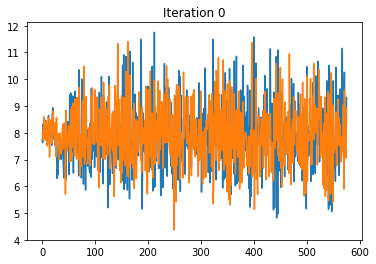

Iterations: 145
Iterations: 290
Iterations: 435
iterations  500
Average P(real)= 0.3878891
Average P(gen)= 0.20027438
Discrim loss: 6147.759


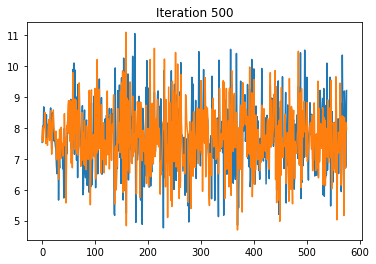

Iterations: 580
Iterations: 725
Iterations: 870
iterations  1000
Average P(real)= 0.37694582
Average P(gen)= 0.22965306
Discrim loss: 4826.4893


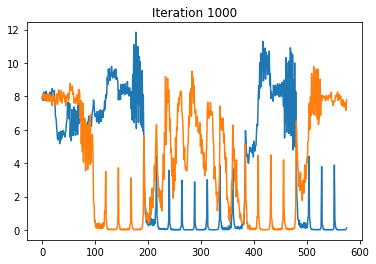

Iterations: 1015
Iterations: 1160
Iterations: 1305
Iterations: 1450
iterations  1500
Average P(real)= 0.37388048
Average P(gen)= 0.216973
Discrim loss: 5141.544


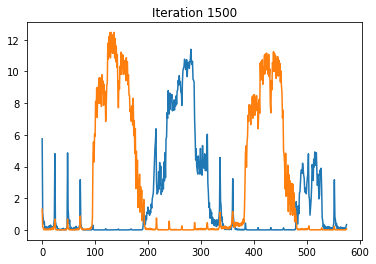

Iterations: 1595
Iterations: 1740
Iterations: 1885
iterations  2000
Average P(real)= 0.3843708
Average P(gen)= 0.22931805
Discrim loss: 5080.7686


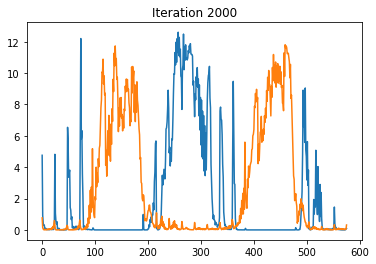

Iterations: 2030
Iterations: 2175
Iterations: 2320
Iterations: 2465
iterations  2500
Average P(real)= 0.38502508
Average P(gen)= 0.2085452
Discrim loss: 5782.893


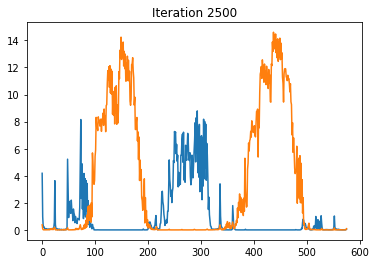

Iterations: 2610
Iterations: 2755
Iterations: 2900
iterations  3000
Average P(real)= 0.31215364
Average P(gen)= 0.3087006
Discrim loss: 113.149414


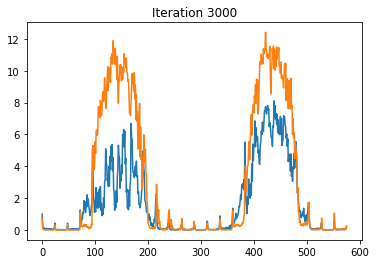

Iterations: 3045
Iterations: 3190
Iterations: 3335
Iterations: 3480
iterations  3500
Average P(real)= 0.32579672
Average P(gen)= 0.317001
Discrim loss: 288.21875


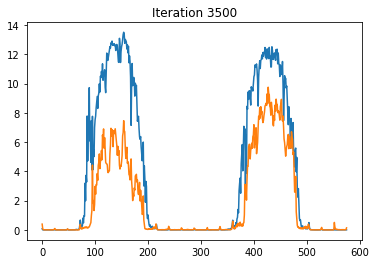

Iterations: 3625
Iterations: 3770
Iterations: 3915
iterations  4000
Average P(real)= 0.3071543
Average P(gen)= 0.30386817
Discrim loss: 107.67969


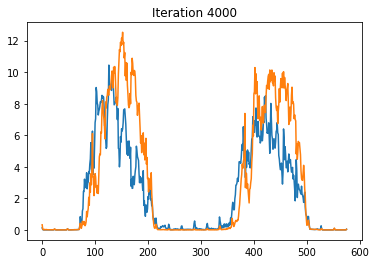

Iterations: 4060
Iterations: 4205
Iterations: 4350
Iterations: 4495
iterations  4500
Average P(real)= 0.30908632
Average P(gen)= 0.2912405
Discrim loss: 584.7715


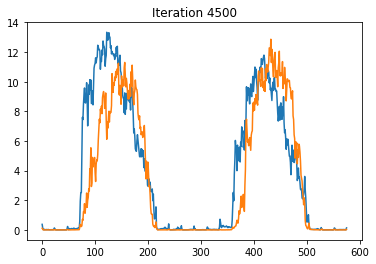

Total number of iterations: 4640


In [12]:
### train.py  file

# Training parameters
maxiters = 4500
learning_rate = 0.0002

# Folder to save generated images to
RUN = 12
folder_name = '/Volumes/Eluteng/cs159/run' + str(RUN) + '/'
#folder_name = 'generative_models/runs/run' + str(RUN) + '/'
if os.path.isdir(folder_name):
    raise ValueError(f'Folder for RUN={RUN} already exists')

!mkdir $folder_name

# Start tensorflow session
#sess.close()
sess = tf.InteractiveSession()
# Start saver to save model during training
saver = tf.train.Saver(max_to_keep=10)

discrim_vars = filter(lambda x: x.name.startswith('discrim'), tf.trainable_variables())
gen_vars = filter(lambda x: x.name.startswith('gen'), tf.trainable_variables())
discrim_vars = [i for i in discrim_vars]
gen_vars = [i for i in gen_vars]

train_op_discrim = (tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(-d_cost_tf, var_list=discrim_vars))
train_op_gen = (tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(g_cost_tf, var_list=gen_vars))

# Z_tf_sample, Y_tf_sample, image_tf_sample: placeholders
Z_tf_sample, Y_tf_sample, image_tf_sample = gan.samples_generator(batch_size=visualize_dim)
tf.initialize_all_variables().run()

iterations = 0
k = 4 #control the balance of training D and G

gen_loss_all=[]
P_real=[]
P_fake=[]
P_distri=[]
discrim_loss=[]


# Begin training
while iterations < maxiters:
    print("Iterations: " + str(iterations))
    
    # Shuffle training data set
    index = np.arange(trX.shape[0])
    np.random.shuffle(index)
    trX = trX[index]
    trY = trY[index]
    trY2 = enc.transform(trY)

    for start, end in zip(
            range(0, trX.shape[0], gan.batch_size),
            range(gan.batch_size, trX.shape[0], gan.batch_size)
            ):

        Xs = trX[start:end].reshape([-1, 24, 24, 1])
        Ys = trY2[start:end]

        #use Gaussian distribution data to generate adversarial samples
        Zs = np.random.normal(mu, sigma, size=[gan.batch_size, gan.dim_z]).astype(np.float32)

        #for each iteration, generate g and d respectively, k=2
        if np.mod( iterations, k) == 0:
            _, gen_loss_val = sess.run(
                    [train_op_gen, g_cost_tf],
                    feed_dict={
                        Z_tf:Zs,
                        Y_tf:Ys,
                        image_tf: Xs
                        })
            discrim_loss_val, p_real_val, p_gen_val = sess.run([d_cost_tf,p_real,p_gen], feed_dict={Z_tf:Zs, Y_tf:Ys, image_tf:Xs})

        else:
            _, discrim_loss_val = sess.run(
                    [train_op_discrim, d_cost_tf],
                    feed_dict={
                        Z_tf:Zs,
                        Y_tf:Ys,
                        image_tf:Xs
                        })

            gen_loss_val, p_real_val, p_gen_val = sess.run([g_cost_tf, p_real, p_gen],
                                                       feed_dict={Z_tf: Zs, image_tf: Xs,  Y_tf: Ys})
        P_real.append(p_real_val.mean())
        P_fake.append(p_gen_val.mean())

        discrim_loss.append(discrim_loss_val)

        if np.mod(iterations, 500) == 0:
            print("iterations ", iterations)
            print("Average P(real)=", p_real_val.mean())
            print("Average P(gen)=", p_gen_val.mean())
            print("Discrim loss:", discrim_loss_val)

            Z_np_sample = np.random.normal(mu, sigma, size=[gan.batch_size, gan.dim_z]).astype(np.float32)
            Y_np_sample = enc.transform(np.random.randint(num_categories, size=[visualize_dim, 1]))
                            
            generated_samples = sess.run(
                image_tf_sample,
                feed_dict={Z_tf_sample: Z_np_sample, Y_tf_sample: Y_np_sample})
            generated_samples = generated_samples.reshape([-1,576])
            generated_samples = generated_samples * gan.max_value
            csvfile = folder_name + f'samples_{iterations}.csv'
            with open(csvfile, 'w') as f:
                writer = csv.writer(f)
                writer.writerows(generated_samples)
                
            plt.figure()
            for sample in generated_samples[:2, :]:
                plt.plot(sample)
            plt.title(f'Iteration {iterations}')
            plt.show()

        iterations += 1

Y_np_sample = enc.transform(np.random.randint(num_categories, size=[visualize_dim, 1]))
Z_np_sample = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)
generated_samples = sess.run(
    image_tf_sample,
    feed_dict={Z_tf_sample: Z_np_sample, Y_tf_sample: Y_np_sample})
generated_samples = generated_samples.reshape([-1,576])
generated_samples = generated_samples * gan.max_value
csvfile = folder_name + 'sample1.csv'
with open(csvfile, 'w')  as f:
    writer = csv.writer(f)
    writer.writerows(generated_samples)
    
# Print total number of iterations
print(f'Total number of iterations: {iterations}')

#plot the loss and P_real as well as P_fake
# print("P_real",P_real)
# print("P_fake",P_fake)

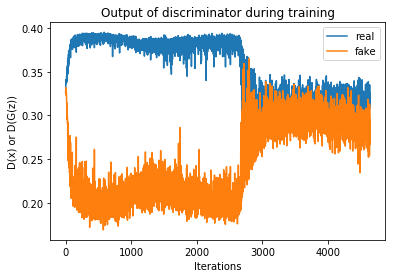

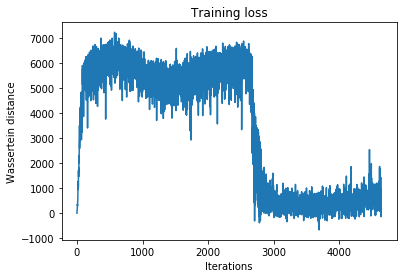

In [71]:
# Plot propobility curves
plt.plot(P_real,label="real")
plt.plot(P_fake,label="fake")
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('D(x) or D(G(z))')
plt.title('Output of discriminator during training')
#plt.savefig('generative_models/figures/D_solar_4600')
plt.show()

plt.plot(discrim_loss)
plt.xlabel('Iterations')
plt.ylabel('Wassertein distance')
plt.title('Training loss')
#plt.savefig('generative_models/figures/loss_solar_4600')
plt.show()

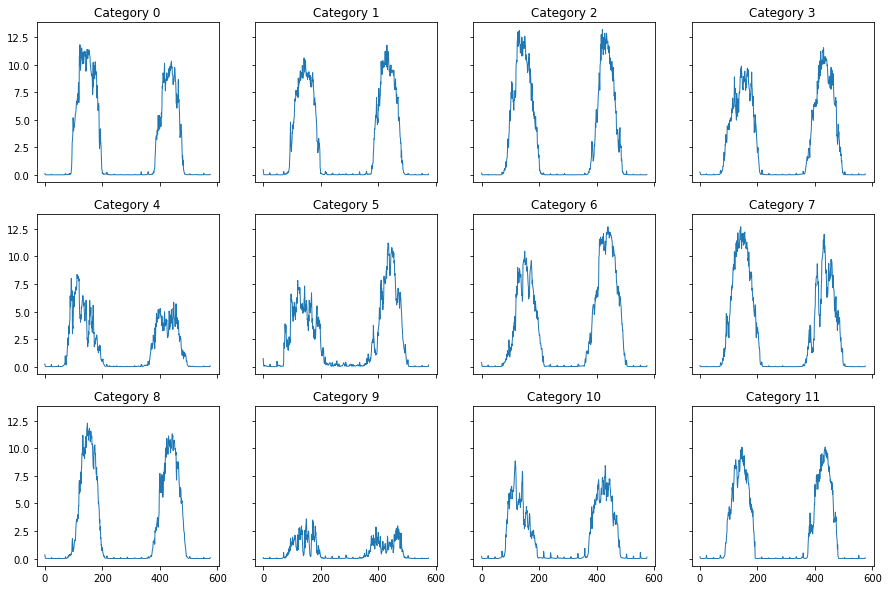

In [28]:
# Generate examples of each category
fig, axes = plt.subplots(3, 4, sharex=True, sharey=True, figsize=(15, 10))
axes = axes.flatten()

for i in range(12):
    ax = axes[i]
    done = False
    while not done:
        y_np_sample = np.random.randint(num_categories, size=(visualize_dim, 1))
        Y_np_sample = enc.transform(y_np_sample)
        Z_np_sample = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)
        generated_samples = sess.run(
                image_tf_sample,
                feed_dict={Z_tf_sample: Z_np_sample,  Y_tf_sample: Y_np_sample})
        generated_samples = generated_samples.reshape([-1,576])
        generated_samples = generated_samples * gan.max_value

        n_subplot = 0
        for sample_id, sample in enumerate(generated_samples):
            if y_np_sample[sample_id][0] == i:
                ax.plot(sample, linewidth=1.)
                done = True
                if n_subplot == 0:
                    break
                else:
                    n_subplot += 1
        ax.title.set_text(f'Category {y_np_sample[sample_id][0]}')

# plt.savefig('../VER_GenerativeModelling_RLAllocation/generative_models/figures'
#             '/solar_categories_examples.png',
#             tight_layout=True)
plt.show()

In [32]:
# # Start saver to save model during training
# saver = tf.train.Saver(max_to_keep=10)
# save_folder = folder_name
# save_path = saver.save(sess, save_folder + 'model')

# # Save encoder
# with open(save_folder + 'encoder_pickle.p', 'wb') as f:
#     pickle.dump(enc, f)

In [76]:
def get_production_per_time_step(x, num_points):
    '''
    Return total power produced during num_points time_steps of x.
    E.g.: if x has a resolution of 5min, setting num_points=12 returns
    the amount of power produced during every hour in x.
    '''
    # Clip x to keep a multiple of num_points points
    max_idx = x.size - x.size % num_points
    temp = x[:max_idx]
    
    # Sum num_consecutive points
    temp = temp.reshape((-1, num_points))
    sums = np.mean(temp, axis=1).flatten()
    
    # Print info
    print(f'Size of original time series: {x.size}')    
    print(f'Size of new time series: {sums.size}')
    
    return sums

def generate_solar_data(num_days=2, labels=None):
    ''' 
    Generate data for num_days days as a single time-series.
    This is done by generating 2-day long time-series, and concatenating them.
    '''
    batch_size = 32
    num_categories = 12
    num_samples = int(num_days / 2) # number of 2-day samples to generate
    
    # Use random labels if none are provided
    if labels is None:
        labels = np.random.randint(num_categories, size=(32 * num_samples, 1))

    labels_one_hot = enc.transform(labels)
    
    # Generate num_days / 2 samples
    all_samples = np.empty((0, 576))
    while all_samples.shape[0] < num_samples:
        
        # Generate a batch of 32 samples
        Z_np_sample = np.random.normal(mu, sigma, size=[batch_size, dim_z]).astype(np.float32)
        Y_np_sample = labels_one_hot[all_samples.shape[0]: all_samples.shape[0] + batch_size, :]
        generated_samples = sess.run(
                image_tf_sample,
                feed_dict={Z_tf_sample: Z_np_sample,  Y_tf_sample: Y_np_sample})
        generated_samples = generated_samples.reshape([-1,576])
        generated_samples = generated_samples * gan.max_value
        
        # Stack the new batch of samples
        subset_index = np.min([32, num_samples - all_samples.shape[0]])
        subset = generated_samples[:subset_index, :]
        all_samples = np.vstack((all_samples, subset))
    
        # Concatenate to return a single time-series
        time_series = all_samples.flatten()
    
    return time_series

In [77]:
# Generate solar data!
num_days = 7
labels = None
new_data = generate_solar_data(num_days, labels)

# Plot newly generated data
plt.figure()
plt.plot(new_data)

# Plot hourly data
hourly_time_series = get_production_per_time_step(new_data, 12)
plt.figure()
plt.plot(hourly_time_series)

TypeError: slice indices must be integers or None or have an __index__ method

array([[1, 2],
       [3, 4],
       [5, 6]])